In [1]:
# Import your updated database
import sys
sys.path.append('../src')
from models.database import CDSDatabase
db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db"
# Create database instance 
db = CDSDatabase(db_path)

# Populate with 10 years of historical data
#db.populate_historical_raw_data(years_back=10)

print("Database creation complete!")

Database creation complete!


In [2]:


# This will ONLY add missing data, not recreate anything
db.update_historical_data()  # Updates from last date in DB to today

# Or if you want to ensure the last 30 days are complete:
# db.update_historical_data(days_back=30)

print("Database update complete!")

Updating historical data...
Updating 6 business days...
Date range: 2025-09-23 to 2025-09-30

Update complete! Added/updated 75 records

Records updated by index:
  EU_IG: 28 records
  EU_XO: 21 records
  US_HY: 3 records
  US_IG: 23 records
Database update complete!


In [3]:
import sqlite3
import pandas as pd

# Connect directly to the database file
db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db"
conn = sqlite3.connect(db_path)

# Check what tables exist
cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in database:")
for table in tables:
    print(f"  - {table[0]}")

# Check if raw_historical_spreads exists and how much data it has
if ('raw_historical_spreads',) in tables:
    # Get total count
    count = conn.execute("SELECT COUNT(*) FROM raw_historical_spreads").fetchone()[0]
    print(f"\nTotal records in raw_historical_spreads: {count:,}")
    
    # Get date range
    cursor = conn.execute("""
        SELECT MIN(date) as min_date, MAX(date) as max_date 
        FROM raw_historical_spreads
    """)
    min_date, max_date = cursor.fetchone()
    print(f"Date range: {min_date} to {max_date}")
    
    # Get breakdown by year
    cursor = conn.execute("""
        SELECT 
            substr(date, 1, 4) as year,
            COUNT(*) as records
        FROM raw_historical_spreads
        GROUP BY substr(date, 1, 4)
        ORDER BY year
    """)
    print("\nRecords by year:")
    for year, count in cursor.fetchall():
        print(f"  {year}: {count:,} records")
    
    # Sample some random dates to see what's there
    cursor = conn.execute("""
        SELECT DISTINCT date 
        FROM raw_historical_spreads 
        ORDER BY date DESC 
        LIMIT 10
    """)
    print("\nMost recent 10 dates with data:")
    for row in cursor.fetchall():
        print(f"  {row[0]}")
        
    cursor = conn.execute("""
        SELECT DISTINCT date 
        FROM raw_historical_spreads 
        ORDER BY date ASC 
        LIMIT 10
    """)
    print("\nOldest 10 dates with data:")
    for row in cursor.fetchall():
        print(f"  {row[0]}")
else:
    print("\nTable 'raw_historical_spreads' does not exist!")

conn.close()

Tables in database:
  - index_definitions
  - spread_data
  - sqlite_sequence
  - curves
  - positions
  - strategies
  - pnl_history
  - raw_historical_spreads

Total records in raw_historical_spreads: 27,141
Date range: 2015-09-21 to 2025-09-30

Records by year:
  2015: 279 records
  2016: 1,056 records
  2017: 1,270 records
  2018: 2,332 records
  2019: 2,976 records
  2020: 2,874 records
  2021: 3,005 records
  2022: 3,022 records
  2023: 3,448 records
  2024: 3,747 records
  2025: 3,132 records

Most recent 10 dates with data:
  2025-09-30
  2025-09-29
  2025-09-26
  2025-09-25
  2025-09-24
  2025-09-23
  2025-09-22
  2025-09-19
  2025-09-18
  2025-09-17

Oldest 10 dates with data:
  2015-09-21
  2015-09-22
  2015-09-23
  2015-09-24
  2015-09-25
  2015-09-28
  2015-09-29
  2015-09-30
  2015-10-01
  2015-10-02


In [4]:
import sqlite3
import pandas as pd

db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db"
conn = sqlite3.connect(db_path)

# Check US_HY 5Y specifically from 2020 onwards
query = """
    SELECT COUNT(*) as count, 
           MIN(date) as min_date, 
           MAX(date) as max_date
    FROM raw_historical_spreads 
    WHERE index_name = 'US_HY' 
    AND tenor = '5Y'
    AND date >= '2020-01-01'
"""
result = pd.read_sql_query(query, conn)
print("US_HY 5Y data from 2020 onwards:")
print(result)

# Get a sample of US_HY 5Y data
query = """
    SELECT date, spread_bps, series_number
    FROM raw_historical_spreads 
    WHERE index_name = 'US_HY' 
    AND tenor = '5Y'
    AND date >= '2020-01-01'
    ORDER BY date DESC
    LIMIT 20
"""
df = pd.read_sql_query(query, conn)
print("\nSample of US_HY 5Y data:")
print(df)

# Check data distribution by index and tenor
query = """
    SELECT index_name, tenor, 
           COUNT(*) as records,
           MIN(date) as first_date,
           MAX(date) as last_date
    FROM raw_historical_spreads
    GROUP BY index_name, tenor
    ORDER BY index_name, tenor
"""
summary = pd.read_sql_query(query, conn)
print("\nData by Index and Tenor:")
print(summary)

conn.close()

US_HY 5Y data from 2020 onwards:
   count    min_date    max_date
0   1438  2020-01-01  2025-09-29

Sample of US_HY 5Y data:
          date  spread_bps  series_number
0   2025-09-29    322.3893             45
1   2025-09-19    304.0244             44
2   2025-09-18    302.8218             44
3   2025-09-17    308.7146             44
4   2025-09-15    304.7187             44
5   2025-09-12    309.5617             44
6   2025-09-11    308.9289             44
7   2025-09-10    316.6946             44
8   2025-09-09    320.9012             44
9   2025-09-08    319.9053             44
10  2025-09-05    319.2550             44
11  2025-09-04    316.8231             44
12  2025-09-03    323.6255             44
13  2025-09-02    324.6922             44
14  2025-09-01    320.7769             44
15  2025-08-29    320.0892             44
16  2025-08-28    316.4462             44
17  2025-08-27    317.5529             44
18  2025-08-26    314.8270             44
19  2025-08-25    315.0488         

In [5]:
from models.database import CDSDatabase


# This should now return all the data
df = db.query_historical_spreads(
    index_name='US_HY', 
    tenor='5Y', 
    start_date='2020-01-01'
)

print(f"US_HY 5Y data points: {len(df)}")  # Should show 1434
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

US_HY 5Y data points: 1438
Date range: 2020-01-01 00:00:00 to 2025-09-29 00:00:00


In [6]:
import sqlite3
import pandas as pd
from pathlib import Path

# Use the same full path for both
db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db"

# Direct SQL query
conn = sqlite3.connect(db_path)
query = """
    SELECT * FROM raw_historical_spreads 
    WHERE index_name = 'US_HY' 
    AND tenor = '5Y' 
    AND date >= '2020-01-01'
    ORDER BY date
"""
df_direct = pd.read_sql_query(query, conn)
print(f"Direct SQL query: {len(df_direct)} records")
print(f"Date range: {df_direct['date'].min()} to {df_direct['date'].max()}")
conn.close()

# Now test the CDSDatabase method WITH THE SAME PATH
from models.database import CDSDatabase

# Use the FULL PATH here - this is the key change
db = CDSDatabase(db_path)  # <-- Using the same full path

df_method = db.query_historical_spreads(
    index_name='US_HY', 
    tenor='5Y', 
    start_date='2020-01-01'
)
print(f"\nCDSDatabase method: {len(df_method)} records")
print(f"Date range: {df_method['date'].min()} to {df_method['date'].max()}")

# Let's also verify which database file the CDSDatabase is actually using
print(f"\nCDSDatabase is using: {db.db_path}")
print(f"File exists: {Path(db.db_path).exists()}")
print(f"File size: {Path(db.db_path).stat().st_size / 1024 / 1024:.2f} MB")

Direct SQL query: 1438 records
Date range: 2020-01-01 to 2025-09-29

CDSDatabase method: 1438 records
Date range: 2020-01-01 00:00:00 to 2025-09-29 00:00:00

CDSDatabase is using: C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db
File exists: True
File size: 4.11 MB


In [7]:


# First check if the table exists and has any data
try:
    count = db.conn.execute("SELECT COUNT(*) FROM raw_historical_spreads").fetchone()[0]
    print(f"Total records in database: {count}")
    
    if count == 0:
        print("\nDatabase is empty! You need to populate it first:")
        print("Run: db.populate_historical_raw_data(years_back=10)")
    else:
        # Query historical data with named parameters
        df = db.query_historical_spreads(
            index_name='US_HY', 
            tenor='3Y', 
            start_date='2020-01-01'
        )
        
        if df.empty:
            print("\nNo US_HY 3Y data found. Let's check what IS in the database:")
            
            # Check what indices and tenors we actually have
            available = db.conn.execute("""
                SELECT DISTINCT index_name, tenor 
                FROM raw_historical_spreads 
                ORDER BY index_name, tenor
            """).fetchall()
            
            print("Available index/tenor combinations:")
            for idx, ten in available:
                print(f"  {idx} - {ten}")
        else:
            print(f"US HY 3Y data points: {len(df)}")
            print(f"Date range: {df['date'].min()} to {df['date'].max()}")
            print("\nSample data:")
            print(df[['date', 'spread_bps', 'series_number', 'bloomberg_ticker']].head())
            
        # Check all indices summary
        summary = db.conn.execute("""
            SELECT index_name, tenor, COUNT(*) as records, 
                   MIN(date) as first_date, MAX(date) as last_date,
                   MIN(series_number) as min_series, MAX(series_number) as max_series
            FROM raw_historical_spreads 
            GROUP BY index_name, tenor
            ORDER BY index_name, tenor
        """).fetchall()
        
        if summary:
            print(f"\nDatabase Summary:")
            for row in summary:
                index_name, tenor, records, first_date, last_date, min_series, max_series = row
                print(f"  {index_name} {tenor}: {records:,} records ({first_date} to {last_date}, S{min_series}-S{max_series})")
        
except Exception as e:
    print(f"Error: {e}")
    print("\nThe table might not exist. Run db.populate_historical_raw_data() first.")

Total records in database: 27141
US HY 3Y data points: 660
Date range: 2020-04-13 00:00:00 to 2025-09-19 00:00:00

Sample data:
        date  spread_bps  series_number      bloomberg_ticker
0 2020-04-13     589.223             34  CDXHY334 BEST Curncy
1 2020-04-14     589.304             34  CDXHY334 BEST Curncy
2 2020-04-15     589.323             34  CDXHY334 BEST Curncy
3 2020-04-16     635.386             34  CDXHY334 BEST Curncy
4 2020-04-17     635.478             34  CDXHY334 BEST Curncy

Database Summary:
  EU_IG 10Y: 2,589 records (2015-09-21 to 2025-09-29, S24-S44)
  EU_IG 1Y: 259 records (2024-09-23 to 2025-09-30, S42-S44)
  EU_IG 3Y: 1,517 records (2019-09-23 to 2025-09-30, S32-S44)
  EU_IG 5Y: 2,526 records (2015-09-21 to 2025-09-30, S24-S44)
  EU_IG 7Y: 1,684 records (2018-09-20 to 2025-09-29, S30-S44)
  EU_XO 10Y: 2,316 records (2016-09-20 to 2025-09-29, S26-S44)
  EU_XO 3Y: 778 records (2022-09-20 to 2025-09-29, S38-S44)
  EU_XO 5Y: 2,539 records (2015-09-21 to 2025-09-

In [8]:


# Query historical data to verify it worked - USE NAMED PARAMETERS
df = db.query_historical_spreads(
    index_name='US_HY', 
    tenor='5Y', 
    start_date='2020-01-01'
)

print(f"US HY 3Y data points: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print("\nSample data:")
print(df[['date', 'spread_bps', 'series_number', 'bloomberg_ticker']].head())

# Check all indices
summary = db.conn.execute("""
    SELECT index_name, tenor, COUNT(*) as records, 
           MIN(date) as first_date, MAX(date) as last_date,
           MIN(series_number) as min_series, MAX(series_number) as max_series
    FROM raw_historical_spreads 
    GROUP BY index_name, tenor
    ORDER BY index_name, tenor
""").fetchall()

print(f"\nDatabase Summary:")
for row in summary:
    index_name, tenor, records, first_date, last_date, min_series, max_series = row
    print(f"  {index_name} {tenor}: {records:,} records ({first_date} to {last_date}, S{min_series}-S{max_series})")

# db.close()

US HY 3Y data points: 1438
Date range: 2020-01-01 00:00:00 to 2025-09-29 00:00:00

Sample data:
        date  spread_bps  series_number      bloomberg_ticker
0 2020-01-01    279.7242             33  CDXHY533 BEST Curncy
1 2020-01-02    275.9299             33  CDXHY533 BEST Curncy
2 2020-01-03    280.5670             33  CDXHY533 BEST Curncy
3 2020-01-06    280.5367             33  CDXHY533 BEST Curncy
4 2020-01-07    282.5547             33  CDXHY533 BEST Curncy

Database Summary:
  EU_IG 10Y: 2,589 records (2015-09-21 to 2025-09-29, S24-S44)
  EU_IG 1Y: 259 records (2024-09-23 to 2025-09-30, S42-S44)
  EU_IG 3Y: 1,517 records (2019-09-23 to 2025-09-30, S32-S44)
  EU_IG 5Y: 2,526 records (2015-09-21 to 2025-09-30, S24-S44)
  EU_IG 7Y: 1,684 records (2018-09-20 to 2025-09-29, S30-S44)
  EU_XO 10Y: 2,316 records (2016-09-20 to 2025-09-29, S26-S44)
  EU_XO 3Y: 778 records (2022-09-20 to 2025-09-29, S38-S44)
  EU_XO 5Y: 2,539 records (2015-09-21 to 2025-09-30, S24-S44)
  EU_XO 7Y: 1,767 r

Testing CDS Database Plotting Capabilities
1. Testing historical spread evolution...
   ✓ Plotted 935 US HY data points
2. Testing current curve visualization...
   ✓ Plotted curves for 4 indices
3. Testing series roll visualization...
   ✓ Plotted 13 different series
4. Testing data quality heatmap...
   ✓ Created availability heatmap for 16 series


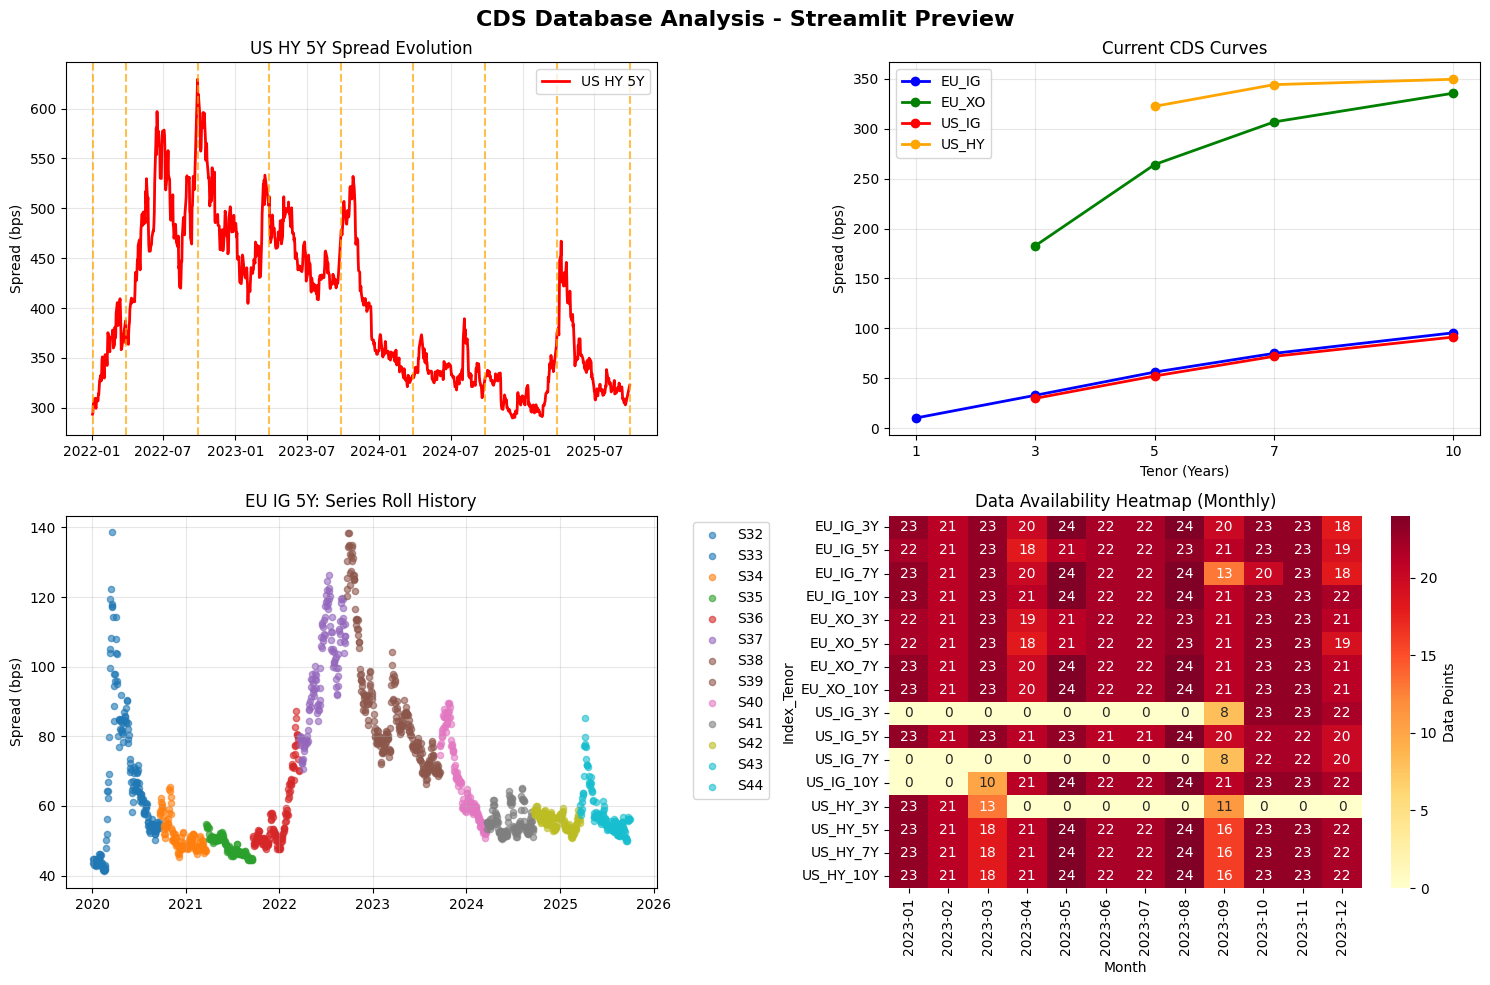


DATABASE SUMMARY STATISTICS
Total Records: 27,141
Date Range: 2015-09-21 to 2025-09-30
Series Range: S24 to S45

Per Index-Tenor Breakdown:
  EU_IG 1Y: 259 records, avg spread: 12.0 bps, range: 6.9-26.0 bps
  EU_IG 3Y: 1,517 records, avg spread: 43.2 bps, range: 20.9-120.2 bps
  EU_IG 5Y: 2,526 records, avg spread: 66.3 bps, range: 41.3-138.5 bps
  EU_IG 7Y: 1,684 records, avg spread: 85.7 bps, range: 61.1-154.2 bps
  EU_IG 10Y: 2,589 records, avg spread: 105.2 bps, range: 80.6-164.0 bps
  EU_XO 3Y: 778 records, avg spread: 298.1 bps, range: 173.2-602.2 bps
  EU_XO 5Y: 2,539 records, avg spread: 323.0 bps, range: 203.7-707.6 bps
  EU_XO 7Y: 1,767 records, avg spread: 371.6 bps, range: 242.1-710.2 bps
  EU_XO 10Y: 2,316 records, avg spread: 383.0 bps, range: 262.7-722.5 bps
  US_HY 3Y: 1,064 records, avg spread: 333.5 bps, range: 180.2-784.4 bps
  US_HY 5Y: 1,927 records, avg spread: 376.4 bps, range: 269.0-781.9 bps
  US_HY 7Y: 1,920 records, avg spread: 399.0 bps, range: 297.7-767.9 

In [9]:
# CDS Database Plotting Test - Preview for Streamlit functionality
# Test plotting capabilities once database is created

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

def test_database_plotting(db):
    """
    Test plotting functions for CDS data - preview of Streamlit functionality
    """
    
    print("Testing CDS Database Plotting Capabilities")
    print("=" * 60)
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CDS Database Analysis - Streamlit Preview', fontsize=16, fontweight='bold')
    
    # Test 1: Historical spread evolution by index
    print("1. Testing historical spread evolution...")
    try:
        # Get US HY 5Y data for last 2 years
        df_hy = db.query_historical_spreads('US_HY', '5Y', 
                                           start_date='2022-01-01')
        
        if not df_hy.empty:
            axes[0,0].plot(df_hy['date'], df_hy['spread_bps'], 
                          linewidth=2, color='red', label='US HY 5Y')
            axes[0,0].set_title('US HY 5Y Spread Evolution')
            axes[0,0].set_ylabel('Spread (bps)')
            axes[0,0].grid(True, alpha=0.3)
            axes[0,0].legend()
            
            # Add series roll markers
            series_changes = df_hy[df_hy['series_number'] != df_hy['series_number'].shift(1)]
            for date in series_changes['date']:
                axes[0,0].axvline(x=date, color='orange', linestyle='--', alpha=0.7)
            
            print(f"   ✓ Plotted {len(df_hy)} US HY data points")
        else:
            axes[0,0].text(0.5, 0.5, 'No US HY data available', 
                          ha='center', va='center', transform=axes[0,0].transAxes)
            
    except Exception as e:
        print(f"   ✗ US HY plotting failed: {e}")
        axes[0,0].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', 
                      transform=axes[0,0].transAxes)
    
    # Test 2: Current curve shapes
    print("2. Testing current curve visualization...")
    try:
        current_curves = {}
        tenors_order = ['1Y', '3Y', '5Y', '7Y', '10Y']
        
        # Get latest data for each index
        for index_name in ['EU_IG', 'EU_XO', 'US_IG', 'US_HY']:
            curve_data = []
            for tenor in tenors_order:
                df = db.query_historical_spreads(index_name, tenor, 
                                                start_date=(datetime.now() - timedelta(days=5)).strftime('%Y-%m-%d'))
                if not df.empty:
                    latest_spread = df.iloc[-1]['spread_bps']
                    curve_data.append({'tenor': tenor, 'spread': latest_spread})
            
            if curve_data:
                current_curves[index_name] = pd.DataFrame(curve_data)
        
        # Plot current curves
        colors = ['blue', 'green', 'red', 'orange']
        tenor_positions = {'1Y': 1, '3Y': 3, '5Y': 5, '7Y': 7, '10Y': 10}
        
        for i, (index_name, curve_df) in enumerate(current_curves.items()):
            if not curve_df.empty:
                x_vals = [tenor_positions[t] for t in curve_df['tenor']]
                axes[0,1].plot(x_vals, curve_df['spread'], 'o-', 
                              color=colors[i % len(colors)], 
                              label=index_name, linewidth=2, markersize=6)
        
        axes[0,1].set_title('Current CDS Curves')
        axes[0,1].set_xlabel('Tenor (Years)')
        axes[0,1].set_ylabel('Spread (bps)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].set_xticks([1, 3, 5, 7, 10])
        
        print(f"   ✓ Plotted curves for {len(current_curves)} indices")
        
    except Exception as e:
        print(f"   ✗ Curve plotting failed: {e}")
        axes[0,1].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', 
                      transform=axes[0,1].transAxes)
    
    # Test 3: Series roll analysis
    print("3. Testing series roll visualization...")
    try:
        # Get EU IG 5Y data to show series changes
        df_eu = db.query_historical_spreads('EU_IG', '5Y', 
                                           start_date='2020-01-01')
        
        if not df_eu.empty:
            # Create scatter plot colored by series
            series_colors = plt.cm.tab10(np.linspace(0, 1, len(df_eu['series_number'].unique())))
            series_color_map = dict(zip(sorted(df_eu['series_number'].unique()), series_colors))
            
            for series_num in sorted(df_eu['series_number'].unique()):
                series_data = df_eu[df_eu['series_number'] == series_num]
                axes[1,0].scatter(series_data['date'], series_data['spread_bps'], 
                                 c=[series_color_map[series_num]], 
                                 label=f'S{series_num}', alpha=0.6, s=20)
            
            axes[1,0].set_title('EU IG 5Y: Series Roll History')
            axes[1,0].set_ylabel('Spread (bps)')
            axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[1,0].grid(True, alpha=0.3)
            
            print(f"   ✓ Plotted {len(df_eu['series_number'].unique())} different series")
        else:
            axes[1,0].text(0.5, 0.5, 'No EU IG data available', 
                          ha='center', va='center', transform=axes[1,0].transAxes)
            
    except Exception as e:
        print(f"   ✗ Series roll plotting failed: {e}")
        axes[1,0].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', 
                      transform=axes[1,0].transAxes)
    
    # Test 4: Data quality heatmap
    print("4. Testing data quality heatmap...")
    try:
        # Create data availability matrix
        date_range = pd.date_range(start='2023-01-01', 
                                  end=datetime.now().strftime('%Y-%m-%d'), freq='D')
        
        indices = ['EU_IG', 'EU_XO', 'US_IG', 'US_HY']
        tenors = ['3Y', '5Y', '7Y', '10Y']  # Common tenors
        
        # Create availability matrix
        availability_matrix = []
        
        for month in pd.date_range(start='2023-01-01', end='2024-12-31', freq='MS')[:12]:
            month_data = {}
            for index_name in indices:
                for tenor in tenors:
                    df = db.query_historical_spreads(
                        index_name, tenor, 
                        start_date=month.strftime('%Y-%m-%d'),
                        end_date=(month + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
                    )
                    month_data[f"{index_name}_{tenor}"] = len(df) if not df.empty else 0
            
            month_data['month'] = month.strftime('%Y-%m')
            availability_matrix.append(month_data)
        
        if availability_matrix:
            avail_df = pd.DataFrame(availability_matrix)
            avail_df.set_index('month', inplace=True)
            
            # Create heatmap
            sns.heatmap(avail_df.T, annot=True, fmt='d', cmap='YlOrRd', 
                       ax=axes[1,1], cbar_kws={'label': 'Data Points'})
            axes[1,1].set_title('Data Availability Heatmap (Monthly)')
            axes[1,1].set_xlabel('Month')
            axes[1,1].set_ylabel('Index_Tenor')
            
            print(f"   ✓ Created availability heatmap for {len(avail_df.columns)} series")
        else:
            axes[1,1].text(0.5, 0.5, 'No data for heatmap', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
            
    except Exception as e:
        print(f"   ✗ Heatmap creation failed: {e}")
        axes[1,1].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', 
                      transform=axes[1,1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*60)
    print("DATABASE SUMMARY STATISTICS")
    print("="*60)
    
    try:
        total_records = db.conn.execute("SELECT COUNT(*) FROM raw_historical_spreads").fetchone()[0]
        
        summary_query = """
            SELECT index_name, tenor, 
                   COUNT(*) as records,
                   MIN(date) as first_date,
                   MAX(date) as last_date,
                   MIN(series_number) as min_series,
                   MAX(series_number) as max_series,
                   AVG(spread_bps) as avg_spread,
                   MIN(spread_bps) as min_spread,
                   MAX(spread_bps) as max_spread
            FROM raw_historical_spreads 
            GROUP BY index_name, tenor
            ORDER BY index_name, 
                     CASE tenor 
                         WHEN '1Y' THEN 1 
                         WHEN '3Y' THEN 2 
                         WHEN '5Y' THEN 3 
                         WHEN '7Y' THEN 4 
                         WHEN '10Y' THEN 5 
                     END
        """
        
        summary_df = pd.read_sql_query(summary_query, db.conn)
        
        print(f"Total Records: {total_records:,}")
        print(f"Date Range: {summary_df['first_date'].min()} to {summary_df['last_date'].max()}")
        print(f"Series Range: S{summary_df['min_series'].min()} to S{summary_df['max_series'].max()}")
        print("\nPer Index-Tenor Breakdown:")
        
        for _, row in summary_df.iterrows():
            print(f"  {row['index_name']} {row['tenor']}: {row['records']:,} records, "
                  f"avg spread: {row['avg_spread']:.1f} bps, "
                  f"range: {row['min_spread']:.1f}-{row['max_spread']:.1f} bps")
        
    except Exception as e:
        print(f"Error generating summary: {e}")
    
    print("\n" + "="*60)
    print("STREAMLIT PREVIEW COMPLETE")
    print("Ready for:")
    print("- Interactive curve plotting")  
    print("- Historical spread analysis")
    print("- Series roll visualization")
    print("- Data quality monitoring")
    print("- Strategy backtesting interface")
    print("="*60)

# Usage in notebook:
test_database_plotting(db)

In [10]:
db.close()

In [11]:
# Daily update - just get recent data
db = CDSDatabase("data/raw/cds_indices_raw.db")

# Update with last 30 days of data (fills any gaps)
db.update_historical_data(days_back=30)

# Or update from where database left off
db.update_historical_data()  # Automatically finds last date and updates from there

# Check for any gaps
db.check_data_gaps('EU_IG', '5Y')

# Fill specific missing dates if needed
missing_dates = db.check_data_gaps()
for date in missing_dates:
    db.update_historical_data(specific_date=date)

Updating historical data...
Updating 6 business days...
Date range: 2025-09-23 to 2025-09-30

Update complete! Added/updated 75 records

Records updated by index:
  EU_IG: 28 records
  EU_XO: 21 records
  US_HY: 3 records
  US_IG: 23 records
Updating historical data...
Database is already up to date
No gaps found - data is complete
No gaps found - data is complete
